In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import pickle

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
tscv = TimeSeriesSplit(n_splits=3)

# **Training Data (2009 - 2024)**

In [4]:
final_data = pd.read_csv('/content/drive/MyDrive/Load Forcasting/Load ForcastingProject/FeatureEngineeringOnGreatBritianElectricityConsumption.csv')

In [5]:
#-> Converting to date time format
final_data['settlement_date'] = pd.to_datetime(final_data['settlement_date'])
final_data.set_index('settlement_date', inplace=True)

final_data = final_data.fillna(value=final_data['nd'].mean())

# Converting textual data to numerical data

for col in ['timeofday','season']:
    if col in final_data.columns:
        one_hot_encoded = pd.get_dummies(final_data[col], prefix=col)
        final_data = final_data.drop(col, axis=1)
        final_data = pd.concat([final_data, one_hot_encoded], axis=1)

# Converting boolian values to numericAL values

for col in final_data.columns:
    if final_data[col].dtype == 'bool':
        final_data[col] = final_data[col].astype(int)

final_data.drop(columns=['month',
       'hour_of_day', 'day_of_week','timeofday_Afternoon', 'season_Autumn'], inplace=True)



In [6]:
final_data.columns

Index(['nd', 'embedded_wind_generation', 'embedded_solar_generation',
       'wind + solar generation', 'year', 'weekend', 'hour_of_day_x',
       'hour_of_day_y', 'week_x', 'week_y', 'month_x', 'month_y',
       'demand_diff', 'wind_diff', 'solar_diff', 'rolling_mean_24',
       'rolling_std_24', 'rolling_mean_48', 'rolling_std_48', 'load_lag_1',
       'load_lag_2', 'load_lag_3', 'load_lag_4', 'load_lag_5', 'load_lag_6',
       'load_lag_48', 'timeofday_Evening', 'timeofday_Morning',
       'timeofday_Night', 'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [7]:
X_data = final_data[[
     'embedded_wind_generation',
     'embedded_solar_generation',
     'wind + solar generation',
      'year', 'weekend',
       'hour_of_day_x', 'hour_of_day_y', 'week_x', 'week_y', 'month_x',
       'month_y', 'demand_diff', 'wind_diff', 'solar_diff', 'rolling_mean_24',
       'rolling_std_24', 'rolling_mean_48', 'rolling_std_48', 'load_lag_1',
       'load_lag_2', 'load_lag_3', 'load_lag_4', 'load_lag_5', 'load_lag_6',
       'load_lag_48', 'timeofday_Evening', 'timeofday_Morning',
       'timeofday_Night', 'season_Spring', 'season_Summer', 'season_Winter']]

y_data = final_data['nd']

# X_train = X_data.iloc[:262195] #-> 14 years of data(2009 - 2023)
# X_test = X_data.iloc[262195:262867]  #-> 2 weeks value (2023 - 2024)

# y_train = y_data.iloc[:262195]
# y_test = y_data.iloc[262195:262867]

# **Testing Data (2025)**

In [8]:
Prediction_Data = pd.read_csv('/content/drive/MyDrive/Load Forcasting/Load ForcastingProject/prediction_data_2025.csv')

In [9]:
Prediction_Data['settlement_date'] = pd.to_datetime(Prediction_Data['settlement_date'])
Prediction_Data.set_index('settlement_date', inplace=True)

In [10]:
Prediction_Data.columns

Index(['nd', 'embedded_wind_generation', 'embedded_solar_generation',
       'wind + solar generation', 'year', 'month', 'hour_of_day',
       'day_of_week', 'weekend', 'timeofday', 'hour_of_day_x', 'hour_of_day_y',
       'week_x', 'week_y', 'month_x', 'month_y', 'season_Winter',
       'season_Spring', 'season_Summer', 'season_Autumn', 'demand_diff',
       'wind_diff', 'solar_diff', 'rolling_mean_24', 'rolling_std_24',
       'rolling_mean_48', 'rolling_std_48', 'load_lag_1', 'load_lag_2',
       'load_lag_3', 'load_lag_4', 'load_lag_5', 'load_lag_6', 'load_lag_48'],
      dtype='object')

In [11]:
Prediction_Data.head()

,nd,embedded_wind_generation,embedded_solar_generation,wind + solar generation,year,month,hour_of_day,day_of_week,weekend,timeofday,...,rolling_std_24,rolling_mean_48,rolling_std_48,load_lag_1,load_lag_2,load_lag_3,load_lag_4,load_lag_5,load_lag_6,load_lag_48
settlement_date,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,21036,5405,0,5405,2025,1,0,2,False,Night,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 00:30:00,21222,5358,0,5358,2025,1,0,2,False,Night,...,NaN,NaN,NaN,21036.0,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 01:00:00,21385,5237,0,5237,2025,1,1,2,False,Night,...,NaN,NaN,NaN,21222.0,21036.0,NaN,NaN,NaN,NaN,NaN
2025-01-01 01:30:00,20473,5115,0,5115,2025,1,1,2,False,Night,...,NaN,NaN,NaN,21385.0,21222.0,21036.0,NaN,NaN,NaN,NaN
2025-01-01 02:00:00,19634,5080,0,5080,2025,1,2,2,False,Night,...,NaN,NaN,NaN,20473.0,21385.0,21222.0,21036.0,NaN,NaN,NaN


In [12]:
Prediction_Data = Prediction_Data.fillna(value=Prediction_Data['nd'].mean())

for col in ['timeofday']:

    if col in Prediction_Data.columns:

        one_hot_encoded = pd.get_dummies(Prediction_Data[col], prefix=col)
        Prediction_Data = Prediction_Data.drop(col, axis=1)
        Prediction_Data = pd.concat([Prediction_Data, one_hot_encoded], axis=1)

for col in Prediction_Data.columns:

    if Prediction_Data[col].dtype == 'bool':
        Prediction_Data[col] = Prediction_Data[col].astype(int)

season_col = Prediction_Data[['season_Autumn',
       'season_Spring', 'season_Summer', 'season_Winter']]

Prediction_Data.drop(columns=['season_Winter', 'season_Spring',
       'season_Summer', 'season_Autumn'] , inplace=True)

Prediction_Data = pd.concat((Prediction_Data,season_col), axis=1 )


In [13]:
Prediction_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3984 entries, 2025-01-01 00:00:00 to 2025-03-24 23:30:00
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   nd                         3984 non-null   int64  
 1   embedded_wind_generation   3984 non-null   int64  
 2   embedded_solar_generation  3984 non-null   int64  
 3   wind + solar generation    3984 non-null   int64  
 4   year                       3984 non-null   int64  
 5   month                      3984 non-null   int64  
 6   hour_of_day                3984 non-null   int64  
 7   day_of_week                3984 non-null   int64  
 8   weekend                    3984 non-null   int64  
 9   hour_of_day_x              3984 non-null   float64
 10  hour_of_day_y              3984 non-null   float64
 11  week_x                     3984 non-null   float64
 12  week_y                     3984 non-null   float64
 13  month_x     

In [14]:
Prediction_Data.columns

Index(['nd', 'embedded_wind_generation', 'embedded_solar_generation',
       'wind + solar generation', 'year', 'month', 'hour_of_day',
       'day_of_week', 'weekend', 'hour_of_day_x', 'hour_of_day_y', 'week_x',
       'week_y', 'month_x', 'month_y', 'demand_diff', 'wind_diff',
       'solar_diff', 'rolling_mean_24', 'rolling_std_24', 'rolling_mean_48',
       'rolling_std_48', 'load_lag_1', 'load_lag_2', 'load_lag_3',
       'load_lag_4', 'load_lag_5', 'load_lag_6', 'load_lag_48',
       'timeofday_Afternoon', 'timeofday_Evening', 'timeofday_Morning',
       'timeofday_Night', 'season_Autumn', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

In [15]:
Prediction_Data.drop(columns=['month',
       'hour_of_day', 'day_of_week' ,'timeofday_Afternoon', 'season_Autumn'], inplace=True)

X_data_pred = Prediction_Data[[
    'embedded_wind_generation',
    'embedded_solar_generation',
    'wind + solar generation',
    'year',
       'weekend', 'hour_of_day_x',
       'hour_of_day_y', 'week_x', 'week_y', 'month_x', 'month_y',
       'demand_diff', 'wind_diff', 'solar_diff', 'rolling_mean_24',
       'rolling_std_24', 'rolling_mean_48', 'rolling_std_48', 'load_lag_1',
       'load_lag_2', 'load_lag_3', 'load_lag_4', 'load_lag_5', 'load_lag_6',
       'load_lag_48', 'timeofday_Evening',
       'timeofday_Morning', 'timeofday_Night',
       'season_Spring', 'season_Summer', 'season_Winter']]

y_data_pred = Prediction_Data['nd']

X_test_pred01 = X_data_pred.iloc[:672]
y_test_pred01 = y_data_pred.iloc[:672]

In [16]:
X_test_pred01.head()

,embedded_wind_generation,embedded_solar_generation,wind + solar generation,year,weekend,hour_of_day_x,hour_of_day_y,week_x,week_y,month_x,...,load_lag_4,load_lag_5,load_lag_6,load_lag_48,timeofday_Evening,timeofday_Morning,timeofday_Night,season_Spring,season_Summer,season_Winter
settlement_date,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,5405,0,5405,2025,0,0.000000,1.000000,0.974928,-0.222521,0.5,...,31260.870984,31260.870984,31260.870984,31260.870984,0,0,1,0,0,1
2025-01-01 00:30:00,5358,0,5358,2025,0,0.000000,1.000000,0.974928,-0.222521,0.5,...,31260.870984,31260.870984,31260.870984,31260.870984,0,0,1,0,0,1
2025-01-01 01:00:00,5237,0,5237,2025,0,0.258819,0.965926,0.974928,-0.222521,0.5,...,31260.870984,31260.870984,31260.870984,31260.870984,0,0,1,0,0,1
2025-01-01 01:30:00,5115,0,5115,2025,0,0.258819,0.965926,0.974928,-0.222521,0.5,...,31260.870984,31260.870984,31260.870984,31260.870984,0,0,1,0,0,1
2025-01-01 02:00:00,5080,0,5080,2025,0,0.500000,0.866025,0.974928,-0.222521,0.5,...,21036.000000,31260.870984,31260.870984,31260.870984,0,0,1,0,0,1


In [17]:
X_data.head()

,embedded_wind_generation,embedded_solar_generation,wind + solar generation,year,weekend,hour_of_day_x,hour_of_day_y,week_x,week_y,month_x,...,load_lag_4,load_lag_5,load_lag_6,load_lag_48,timeofday_Evening,timeofday_Morning,timeofday_Night,season_Spring,season_Summer,season_Winter
settlement_date,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,54,0,54,2009,0,0.000000,1.000000,0.433884,-0.900969,0.5,...,31178.730538,31178.730538,31178.730538,31178.730538,0,0,1,0,0,1
2009-01-01 00:30:00,53,0,53,2009,0,0.000000,1.000000,0.433884,-0.900969,0.5,...,31178.730538,31178.730538,31178.730538,31178.730538,0,0,1,0,0,1
2009-01-01 01:00:00,53,0,53,2009,0,0.258819,0.965926,0.433884,-0.900969,0.5,...,31178.730538,31178.730538,31178.730538,31178.730538,0,0,1,0,0,1
2009-01-01 01:30:00,50,0,50,2009,0,0.258819,0.965926,0.433884,-0.900969,0.5,...,31178.730538,31178.730538,31178.730538,31178.730538,0,0,1,0,0,1
2009-01-01 02:00:00,50,0,50,2009,0,0.500000,0.866025,0.433884,-0.900969,0.5,...,37910.000000,31178.730538,31178.730538,31178.730538,0,0,1,0,0,1


# **Correlation**

In [18]:
import seaborn as sns
correlation = final_data.corr()

# # Plot only features vs target
# plt.figure(figsize=(12, 8))
# sns.heatmap(
#     correlation[['nd']].sort_values(by='nd', ascending=False),
#     annot=True, cmap='coolwarm'
# )
# plt.title("Correlation of Features with Target (nd)")
# plt.show()


In [19]:
correlation[['nd']].sort_values(by='nd', ascending=False)

,nd
nd,1.000000
load_lag_1,0.990802
load_lag_2,0.965557
load_lag_48,0.931405
load_lag_3,0.927444
load_lag_4,0.880291
load_lag_5,0.827040
load_lag_6,0.770484
rolling_mean_48,0.701057
rolling_mean_24,0.611887


# **Feature Importance**

In [ ]:
# Fit a Random Forest to find feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=2)
rf_model.fit(X_data, y_data)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

In [28]:
feature_names = X_data.columns

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("--- Feature Importances from Random Forest ---")
print(feature_importance_df)

# # Plotting the feature importances
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
# plt.title('Random Forest Feature Importances')
# plt.xlabel('Importance (Mean Decrease in Impurity)')
# plt.ylabel('Feature')
# plt.grid(axis='x', linestyle='--')
# plt.tight_layout()
# plt.show()

--- Feature Importances from Random Forest ---
                      Feature    Importance
19                 load_lag_1  9.623174e-01
3           total_consumption  2.492849e-02
12                demand_diff  1.141857e-02
2     wind + solar generation  1.030587e-03
0    embedded_wind_generation  2.873847e-04
1   embedded_solar_generation  2.194977e-06
18             rolling_std_48  1.331280e-06
25                load_lag_48  1.255356e-06
16             rolling_std_24  1.121941e-06
20                 load_lag_2  1.067865e-06
4                        year  1.042902e-06
15            rolling_mean_24  1.039220e-06
13                  wind_diff  9.878084e-07
17            rolling_mean_48  9.378252e-07
21                 load_lag_3  7.121228e-07
24                 load_lag_6  6.679820e-07
23                 load_lag_5  6.354368e-07
22                 load_lag_4  6.101220e-07
6               hour_of_day_x  5.397536e-07
8                      week_x  5.323587e-07
11                    month_y

# **ACF & PACF Plot**

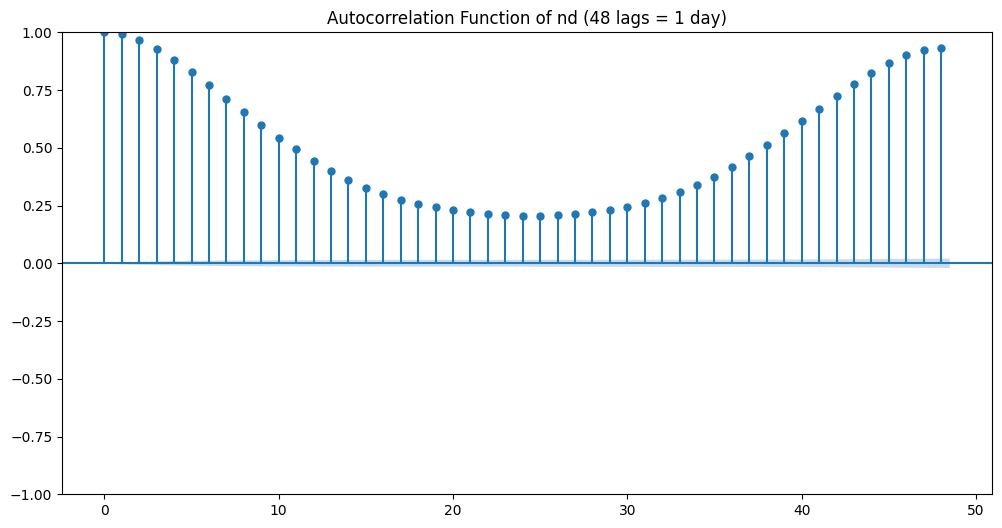

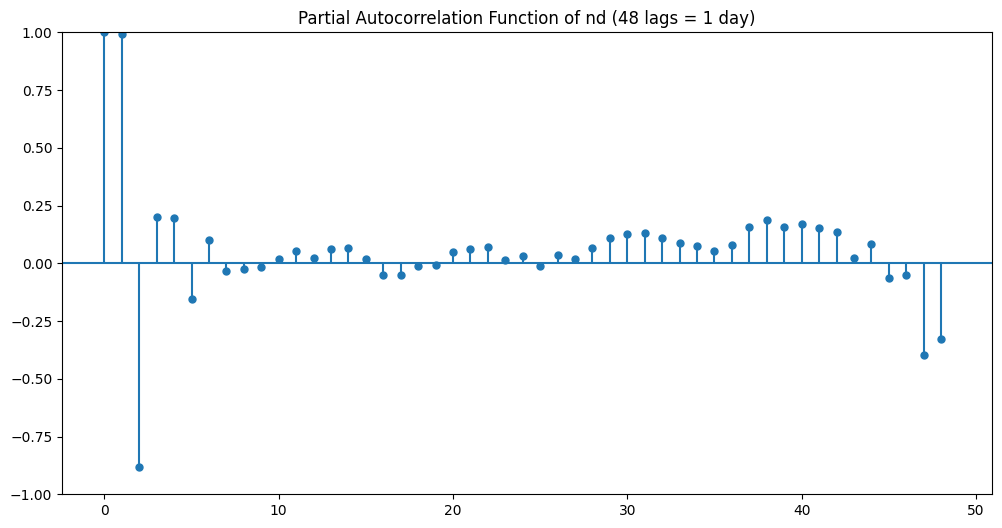

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(final_data['nd'].dropna(), lags=48, ax=plt.gca(), title='Autocorrelation Function of nd (48 lags = 1 day)')
plt.show()

# Plot Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(final_data['nd'].dropna(), lags=48, ax=plt.gca(), title='Partial Autocorrelation Function of nd (48 lags = 1 day)')
plt.show()

# **Permutation(LastStep)**

In [ ]:
# from sklearn.inspection import permutation_importance

# # Calculate Permutation Importance
# # This can be computationally intensive for large datasets/models
# result = permutation_importance(rf_model, X_data, y_data, n_repeats=5, random_state=42, n_jobs=-1)

# # Organize and print results
# perm_importance_df = pd.DataFrame({
#     'Feature': X_data.columns,
#     'Permutation_Importance': result.importances_mean,
#     'Std_Dev': result.importances_std
# })
# perm_importance_df = perm_importance_df.sort_values(by='Permutation_Importance', ascending=False)

# print("\n--- Permutation Importances ---")
# print(perm_importance_df)

# **Linear Regression**

In [223]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_data, y_data)


LinearRegression()

In [224]:
y_pred_lr25 = lr.predict(X_test_pred01)


In [225]:
# Metrics
mae_lr = mean_absolute_error(y_test_pred01, y_pred_lr25)
rmse_lr = np.sqrt(mean_squared_error(y_test_pred01, y_pred_lr25))
r2_lr = r2_score(y_test_pred01, y_pred_lr25)

print("Linear Regression Results:")
print(f"MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R²: {r2_lr:.4f}")

Linear Regression Results:
MAE: 65.48, RMSE: 1029.90, R²: 0.9768


In [226]:
import pickle

# Save model
with open('/content/drive/MyDrive/LR.pkl', 'wb') as f:
    pickle.dump(lr, f)

# **Ridge Regression**

In [227]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = Ridge()
gs_ridge = GridSearchCV(ridge, ridge_params, scoring='neg_root_mean_squared_error', cv=tscv)

gs_ridge.fit(X_data, y_data)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.64581e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.98385e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Ridge(), param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_root_mean_squared_error')

In [228]:
y_pred_ridge25 = gs_ridge.predict(X_test_pred01)

In [229]:
# Metrics
mae_ridge = mean_absolute_error(y_test_pred01, y_pred_ridge25)
rmse_ridge  = np.sqrt(mean_squared_error(y_test_pred01, y_pred_ridge25))
r2_ridge  = r2_score(y_test_pred01, y_pred_ridge25)

print("Linear Ridge Results:")
print(f"MAE: {mae_ridge :.2f}, RMSE: {rmse_ridge :.2f}, R²: {r2_ridge :.4f}")

Linear Ridge Results:
MAE: 65.48, RMSE: 1029.90, R²: 0.9768


In [230]:
import pickle

# Save model
with open('/content/drive/MyDrive/Ridge.pkl', 'wb') as f:
    pickle.dump(gs_ridge, f)

# **Lasso Regression**

In [231]:
from sklearn.linear_model import Lasso

lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

lasso = Lasso(max_iter=10000)
gs_lasso = GridSearchCV(lasso, lasso_params, scoring='neg_root_mean_squared_error', cv=tscv)
gs_lasso.fit(X_data, y_data)



GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Lasso(max_iter=10000),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='neg_root_mean_squared_error')

In [232]:
y_pred_lasso25 = gs_lasso.predict(X_test_pred01)

In [233]:
# Metrics
mae_lasso = mean_absolute_error(y_test_pred01, y_pred_lasso25)
rmse_lasso  = np.sqrt(mean_squared_error(y_test_pred01, y_pred_lasso25))
r2_lasso  = r2_score(y_test_pred01, y_pred_lasso25)

print("Linear Regression Results:")
print(f"MAE: {mae_lasso :.2f}, RMSE: {rmse_lasso :.2f}, R²: {r2_lasso :.4f}")

Linear Regression Results:
MAE: 65.58, RMSE: 1029.26, R²: 0.9768


In [234]:
import pickle

# Save model
with open('/content/drive/MyDrive/Lasso.pkl', 'wb') as f:
    pickle.dump(gs_lasso, f)

# **EkasticNet Regression**

In [236]:
from sklearn.linear_model import ElasticNet

enet_params = {
    'alpha': [0.01, 0.1, 1],
    'l1_ratio': [0.1, 0.5, 0.9]  # Ratio between L1 and L2
}

enet = ElasticNet(max_iter=10000)
gs_enet = GridSearchCV(enet, enet_params, scoring='neg_root_mean_squared_error', cv=3)
gs_enet.fit(X_data, y_data)


GridSearchCV(cv=3, estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]},
             scoring='neg_root_mean_squared_error')

In [237]:
y_pred_enet25 = gs_enet.predict(X_test_pred01)

In [238]:
# Metrics
mae_enet = mean_absolute_error(y_test_pred01, y_pred_enet25)
rmse_enet  = np.sqrt(mean_squared_error(y_test_pred01, y_pred_enet25))
r2_enet  = r2_score(y_test_pred01, y_pred_enet25)

print("Linear Regression Results:")
print(f"MAE: {mae_enet :.2f}, RMSE: {rmse_enet :.2f}, R²: {r2_enet :.4f}")

Linear Regression Results:
MAE: 65.67, RMSE: 1033.45, R²: 0.9766


In [239]:
import pickle

# Save model
with open('/content/drive/MyDrive/ElasticNet.pkl', 'wb') as f:
    pickle.dump(gs_enet, f)

# **SARIMAX**

In [71]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# X_exog = final_data[[
#     'load_lag_1',
#     'rolling_mean_24',
#     'rolling_std_24',
#     'demand_diff',

#     'hour_of_day_x',
#     'hour_of_day_y',

#     'season_Spring',
#     'season_Summer',
#     'season_Winter'
# ]]

In [81]:
# from pmdarima import auto_arima

# stepwise_model = auto_arima(
#     y_data,
#     exogenous=X_exog,
#     seasonal=True,
#     m=24,
#     d=1, D=1,
#     start_p=1, start_q=1,
#     max_p=1, max_q=1,
#     start_P=1, start_Q=1,
#     max_P=1, max_Q=1,
#     stepwise=False,
#     trace=True
# )


In [ ]:

# model = SARIMAX(y_data, exog=X_exog, order=(1,1,1), seasonal_order=(1,1,1,24))
# results = model.fit()


In [82]:
# forecast = results.predict(start=len(y), end=len(y)+47, exog=X_test_pred01[[
#     'load_lag_1',
#     'rolling_mean_24',
#     'rolling_std_24',
#     'demand_diff',

#     'hour_of_day_x',
#     'hour_of_day_y',

#     'season_Spring',
#     'season_Summer',
#     'season_Winter'
# ]])


In [83]:

# # Metrics
# mae_sarimax = mean_absolute_error(y_data_pred01, forecast)
# rmse_sarimax = np.sqrt(mean_squared_error(y_data_pred01, forecast))
# r2_sarimax = r2_score(y_data_pred01, forecast)

# print("SARIMAX: ")
# print(f"MAE: {mae_sarimax:.2f}, RMSE: {rmse_sarimax:.2f}, R²: {r2_sarimax:.4f}")

In [84]:
# import pickle

# # Save model
# with open('/content/drive/MyDrive/SARIMAX.pkl', 'wb') as f:
#     pickle.dump(results, f)

# **KNN**

In [39]:
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)
y_data_scaled = scaler.fit_transform(y_data.values.reshape(-1, 1))

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]   # 1 = Manhattan, 2 = Euclidean
}

# Initialize model
knn = KNeighborsRegressor()

# Randomized search
rs_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=knn_params,
    scoring='neg_root_mean_squared_error',
    n_iter=10,
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=1
)

In [42]:
# # Fit on scaled data
# rs_knn.fit(X_data_scaled, y_data_scaled)

In [ ]:

# Best model
best_knn = rs_knn.best_estimator_

# Predict on test data
y_pred_knn = best_knn.predict(X_data_scaled)

In [ ]:
# Inverse transform predictions and true values if needed
y_pred_inv = scaler.inverse_transform(y_pred_knn.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test_scaled)

# Evaluate
mae_knn = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_knn = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2_knn = r2_score(y_test_inv, y_pred_inv)

print("Best KNN Parameters:", rs_knn.best_params_)
print(f"MAE: {mae_knn:.2f}, RMSE: {rmse_knn:.2f}, R²: {r2_knn:.4f}")

In [ ]:
import pickle

# Save model
with open('/content/drive/MyDrive/KNN.pkl', 'wb') as f:
    pickle.dump(best_knn, f)

# **Random Forest**

In [67]:
param_grid = {
    'n_estimators': [50, 100],         # 2 options
    'max_depth': [None, 10],           # 2 options
    'max_features': [0.5, 1.0],        # 2 options
    'max_samples': [0.5, 0.75, 1.0]    # 3 options
}

rf = RandomForestRegressor()

rs_cv = RandomizedSearchCV(estimator=rf,
                          param_distributions = param_grid,
                          n_iter=8,
                          cv = tscv,
                          verbose = 2 ,
                          n_jobs = -1)

rs_cv.fit(X_data, y_data)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=8, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10],
                                        'max_features': [0.5, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0],
                                        'n_estimators': [50, 100]},
                   verbose=2)

In [68]:

best_rf = rs_cv.best_estimator_

y_pred_rf25 = best_rf.predict(X_test_pred01)

In [69]:

mae_rf = mean_absolute_error(y_test_pred01, y_pred_rf25)
rmse_rf = np.sqrt(mean_squared_error(y_test_pred01, y_pred_rf25))
r2_rf = r2_score(y_test_pred01, y_pred_rf25)

print(f"MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.4f}")

MAE: 33.04, RMSE: 612.98, R²: 0.9918


In [70]:
import pickle

# Save model
with open('/content/drive/MyDrive/RF.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

# **AdaBoost**

In [ ]:
ada_model = AdaBoostRegressor(random_state=42)

ada_params = {
    'n_estimators': [20,40,60],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'loss': ['linear', 'square', 'exponential']
}

rs_ada = RandomizedSearchCV(ada_model, ada_params, cv=tscv, n_iter=10, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

rs_ada.fit(X_data, y_data)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=AdaBoostRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [20, 40, 60]},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
ada_best = rs_ada.best_estimator_
ada_pred25 = ada_best.predict(X_test_pred01)

In [ ]:
print("AdaBoost MAE:", mean_absolute_error(y_test_pred01, ada_pred25))
print("AdaBoost RMSE:", np.sqrt(mean_squared_error(y_test_pred01, ada_pred25)))
print("AdaBoost R²:", r2_score(y_test_pred01, ada_pred25))

AdaBoost MAE: 869.9394919128014
AdaBoost RMSE: 1163.7087599281767
AdaBoost R²: 0.9703443487790507


In [65]:
import pickle

# Save model
with open('/content/drive/MyDrive/AdaBoost.pkl', 'wb') as f:
    pickle.dump(ada_best, f)

# **Gradient Boost**

In [ ]:
gbr_model = GradientBoostingRegressor(random_state=42)

gbr_params = {
    'n_estimators': [60, 100],        # 2 options
    'learning_rate': [0.05, 0.1],     # 2 options
    'max_depth': [3, 5],              # 2 options
    'subsample': [0.6, 0.9, 1.0]      # 3 options
}

rs_gbr = RandomizedSearchCV(gbr_model, gbr_params, cv=tscv, n_iter=10, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
rs_gbr.fit(X_data, y_data)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=GradientBoostingRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [60, 100],
                                        'subsample': [0.6, 0.9, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:

gbr_best = rs_gbr.best_estimator_
gbr_pred25 = gbr_best.predict(X_test_pred01)

In [ ]:
print("Gradient Boosting MAE:", mean_absolute_error(y_test_pred01, gbr_pred25))
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test_pred01, gbr_pred25)))
print("Gradient Boosting R²:", r2_score(y_test_pred01, gbr_pred25))

Gradient Boosting MAE: 82.64471052244839
Gradient Boosting RMSE: 636.3939645393903
Gradient Boosting R²: 0.991131075400235


In [66]:
import pickle

# Save model
with open('/content/drive/MyDrive/GradientBoost.pkl', 'wb') as f:
    pickle.dump(gbr_best, f)

# **XGBoost**

In [240]:
xgb_model = XGBRegressor(random_state=42, verbosity=0)

xgb_params = {
    'n_estimators': [50, 90],            # fewer boosting rounds for speed
    'learning_rate': [0.05, 0.1],        # reasonable learning rates
    'max_depth': [3, 5],                 # controls tree complexity
    'subsample': [0.8],                  # row sampling
    'colsample_bytree': [0.8],           # column sampling
    'reg_alpha': [0.1],                  # light L1 regularization
    'reg_lambda': [1.0, 2.0]             # L2 regularization
}

rs_xgb = RandomizedSearchCV(xgb_model, xgb_params, cv=tscv, n_iter=10, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
rs_xgb.fit(X_data, y_data)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [50, 90],
                                        'reg_alpha': [0.1],
                                        'reg_lambda': [1.0, 2.0],
                                        'subsample': [0.8]},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [241]:
xgb_best = rs_xgb.best_estimator_
xgb_pred25 = xgb_best.predict(X_test_pred01)

In [242]:
print("XGBoost RMSE:", mean_absolute_error(y_test_pred01, xgb_pred25))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test_pred01, xgb_pred25)))
print("XGBoost R²:", r2_score(y_test_pred01, xgb_pred25))

XGBoost RMSE: 126.55773162841797
XGBoost RMSE: 569.0239724739196
XGBoost R²: 0.9929094314575195


In [243]:
import pickle

# Save model
with open('/content/drive/MyDrive/XGBoost.pkl', 'wb') as f:
    pickle.dump(xgb_best, f)


# **xgboost Light**

In [244]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

lgb_model = LGBMRegressor(random_state=42)

lgb_params = {
    'n_estimators': [100, 200],            # fewer boosting rounds for faster training
    'learning_rate': [0.05, 0.1],          # balanced step size
    'max_depth': [-1, 10],                 # -1 = no limit, 10 = controlled complexity
    'num_leaves': [31],                    # default, sufficient for many cases
    'subsample': [0.9],                    # mild row sampling
    'colsample_bytree': [0.8],             # column sampling to reduce overfitting
    'reg_alpha': [0.0, 0.1],               # light L1 regularization
    'reg_lambda': [1.0]                    # default L2 regularization
}

rs_lgb = RandomizedSearchCV(lgb_model, lgb_params, cv=tscv, n_iter=10,
                            scoring='neg_root_mean_squared_error',
                            verbose=2, n_jobs=-1)

In [245]:
rs_lgb.fit(X_data, y_data)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4441
[LightGBM] [Info] Number of data points in the train set: 279809, number of used features: 31
[LightGBM] [Info] Start training from score 31178.730538


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [100, 200],
                                        'num_leaves': [31],
                                        'reg_alpha': [0.0, 0.1],
                                        'reg_lambda': [1.0],
                                        'subsample': [0.9]},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [246]:
lgb_best = rs_lgb.best_estimator_
lgb_pred25 = lgb_best.predict(X_test_pred01)


In [247]:
print("LightGBM MAE:", mean_absolute_error(y_test_pred01, lgb_pred25))
print("LightGBM RMSE:", np.sqrt(mean_squared_error(y_test_pred01, lgb_pred25)))
print("LightGBM R²:", r2_score(y_test_pred01, lgb_pred25))

LightGBM MAE: 112.46910814883837
LightGBM RMSE: 564.5272090758536
LightGBM R²: 0.9930210736355772


In [249]:
import pickle

# Save model
with open('/content/drive/MyDrive/LightGradientBoost.pkl', 'wb') as f:
    pickle.dump(lgb_best, f)


In [250]:
!pip install catboost

# **Cat Boost**

In [251]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

cat_model = CatBoostRegressor(verbose=0, random_state=42)

cat_params = {
    'iterations': [150, 300],         # 2 options
    'learning_rate': [0.05, 0.1],     # 2 options
    'depth': [4, 6],                  # 2 options
    'subsample': [0.9, 1.0]           # 2 options
}

In [252]:
rs_cat = RandomizedSearchCV(cat_model, cat_params, cv=tscv, n_iter=10,
                            scoring='neg_root_mean_squared_error',
                            verbose=2, n_jobs=-1)

rs_cat.fit(X_data, y_data)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7dd2e6142b90>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 6],
                                        'iterations': [150, 300],
                                        'learning_rate': [0.05, 0.1],
                                        'subsample': [0.9, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [253]:
cat_best = rs_cat.best_estimator_
cat_pred25 = cat_best.predict(X_test_pred01)


In [254]:
print("CatBoost RMSE:", mean_absolute_error(y_test_pred01, cat_pred25))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test_pred01, cat_pred25)))
print("CatBoost R²:", r2_score(y_test_pred01, cat_pred25))

CatBoost RMSE: 100.58495211331869
CatBoost RMSE: 590.5990297246962
CatBoost R²: 0.9923615662442624


In [255]:
import pickle

# Save model
with open('/content/drive/MyDrive/CatGradientBoost.pkl', 'wb') as f:
    pickle.dump(cat_best, f)


In [ ]:
with open('/content/drive/MyDrive/GradientBoost.pkl', 'rb') as f:
    trained_model = pickle.load(f)

In [ ]:
mod = trained_model.predict(X_test)

print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, mod)))

CatBoost RMSE: 71.132846241572


# **Voting**

In [35]:
from sklearn.ensemble import VotingRegressor

# 1. Load models
def load_model(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

ridge = load_model('/content/drive/MyDrive/AdaBoost.pkl')
rf = load_model('/content/drive/MyDrive/RF.pkl')
xgb = load_model('/content/drive/MyDrive/XGBoost.pkl')
# knn = load_model('/content/drive/MyDrive/TuneKNN.pkl')

# 2. Validation data (replace with your actual validation data)
# Assume you already have X_val, y_val
# If not, split it here for testing
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [36]:
### ---- A. Voting Regressor (Simple Averaging) ---- ###
voting = VotingRegressor([
    ('ridge', ridge),
    ('rf', rf),
    ('xgb', xgb)
    # ('knn', knn)
])

In [37]:
voting.fit(X_data, y_data)
voting_preds = voting.predict(X_test_pred01)
# voting_rmse = np.sqrt(mean_squared_error(y_test, voting_preds))
# print("Voting RMSE:", voting_rmse)

In [38]:
voting_rmse = np.sqrt(mean_squared_error(y_test_pred01, voting_preds))
print("Voting RMSE:", voting_rmse)

Voting RMSE: 647.1737250688689


In [ ]:
import pickle

# Save model
with open('/content/drive/MyDrive/Voting.pkl', 'wb') as f:
    pickle.dump(voting, f)

# **Stacking**

In [ ]:
# Define the base models for stacking
# Using the loaded, already fitted models
base_estimators = [
    ('ridge', ridge),
    ('rf', rf),
    ('xgb', xgb),
    ('catboost', CatBoost)
]

In [ ]:
# Step 1: Generate out-of-fold predictions for meta-model training
# Use TimeSeriesSplit for time series data.
tscv = TimeSeriesSplit(n_splits=5)

# Initialize array to store meta-features (predictions from base models on training data)
# Use X_train.shape[0] as X_train is the data you're splitting
meta_features_train = np.zeros((X_train.shape[0], len(base_estimators)))

print(f"Generating out-of-fold predictions from base models ({tscv.n_splits} folds)...")
for i, (name, model) in enumerate(base_estimators):
    print(f"  Processing base model: {name}")

    fold_preds = np.zeros(X_train.shape[0]) # Store predictions for this base model across all folds

    # Iterate through each time series split
    # tscv.split operates on X_train and y_train
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train, y_train)):
        print(f"    Sub-processing Fold {fold + 1}/{tscv.n_splits} for model {name}")

        # --- CRITICAL FIX: Use X_train for prediction (unscaled) ---
        # model.predict expects input consistent with its training.
        # Since you're not scaling, X_train is the correct input.
        fold_preds[val_idx] = model.predict(X_train.iloc[val_idx]) # Use .iloc for DataFrame indexing

    meta_features_train[:, i] = fold_preds # Store predictions for this base model


In [ ]:
# Step 2: Train the meta-model on the generated meta-features
# Simple and effective meta-model
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()

print("Training meta-model on out-of-fold predictions...")
meta_model.fit(meta_features_train, y_train)

In [ ]:
# Step 3: Generate predictions for the final test set
# First, get predictions from all base models on the *final* X_test_scaled
print("Generating final test predictions from base models...")
meta_features_test = np.column_stack([
    model.predict(X_test) for name, model in base_estimators
])

# Then, use the trained meta-model to make the final stacking predictions
print("Making final stacking predictions using meta-model...")
stacking_preds = meta_model.predict(meta_features_test)

In [ ]:
# Step 4: Evaluate the Stacking Regressor
stacking_mse = mean_squared_error(y_test, stacking_preds)
stacking_rmse = np.sqrt(stacking_mse)
stacking_r2 = r2_score(y_test, stacking_preds)

print(f"\n--- Stacking Regressor Results ---")
print(f"  MSE: {stacking_mse:.4f}")
print(f"  RMSE: {stacking_rmse:.4f}")
print(f"  R²: {stacking_r2:.4f}")

print("\nStacking Regressor implementation complete.")

# **Blending**

In [ ]:
# Define the base models for blending
base_estimators = [
    ('ridge', ridge),
    ('rf', rf),
    ('xgb', xgb),
    ('catboost', CatBoost)
]

In [ ]:
# Step 1: Split the original training data into a base training set and a blending validation set.
# This blending_val_set is used to train the meta-model.
# For time series, it's crucial to use shuffle=False to maintain temporal order.
# The `test_size` here determines the proportion of your *training data* that becomes the blending validation set.
# A common split is 70-30 or 80-20. Here, we'll use 80% for base_train and 20% for blend_val.
X_base_train = X_train.copy()
X_blend_val = X_test.copy()
y_base_train = y_train.copy()
y_blend_val = y_test.copy()

print(f"Original training data split for blending:")
print(f"  Base Training Set Size: {len(X_base_train)}")
print(f"  Blending Validation Set Size: {len(X_blend_val)}")

In [ ]:
# Step 2: Generate predictions from base models on the blending validation set.
# Since your base models are already trained on the full X_train_scaled,
# we directly predict on X_blend_val.

print("Generating predictions from base models on the blending validation set...")
meta_features_blend_val = np.column_stack([
    model.predict(X_blend_val) for name, model in base_estimators
])

In [ ]:
# Step 3: Train the meta-model on these predictions
meta_model_blend = LinearRegression() # Simple and effective meta-model for blending

print("Training meta-model for blending...")
meta_model_blend.fit(meta_features_blend_val, y_blend_val)

In [ ]:
# Step 4: Generate predictions for the final test set
# First, get predictions from all base models on the *final* X_test_scaled
print("Generating final test predictions from base models for blending...")

meta_features_test_blend = np.column_stack([
    model.predict(X_test) for name, model in base_estimators
])

# Then, use the trained meta-model to make the final blending predictions
print("Making final blending predictions using meta-model...")
blending_preds = meta_model_blend.predict(meta_features_test_blend)


In [ ]:
# Step 5: Evaluate the Blending Regressor
blending_mse = mean_squared_error(y_test, blending_preds)
blending_rmse = np.sqrt(blending_mse)
blending_r2 = r2_score(y_test, blending_preds)

print(f"\n--- Blending Regressor Results ---")
print(f"  MSE: {blending_mse:.4f}")
print(f"  RMSE: {blending_rmse:.4f}")
print(f"  R²: {blending_r2:.4f}")

print("\nBlending Regressor implementation complete (Time Series Aware).")